In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

plt.style.use('seaborn-poster')

### **Exploración de los datos**

In [185]:
df = pd.read_csv('./../data/Solar_Energy_Production.csv')
df.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 08:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 09:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258423 entries, 0 to 258422
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              258423 non-null  object 
 1   id                258423 non-null  int64  
 2   address           258423 non-null  object 
 3   date              258423 non-null  object 
 4   kWh               258423 non-null  float64
 5   public_url        258423 non-null  object 
 6   installationDate  258423 non-null  object 
 7   uid               258423 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 15.8+ MB


#### Sitios con instalaciones de paneles solares

In [187]:
df['name'].unique()

array(['Calgary Fire Hall Headquarters', 'Whitehorn Multi-Service Centre',
       'Southland Leisure Centre',
       'Hillhurst Sunnyside Community Association',
       'Glenmore Water Treatment Plant',
       'City of Calgary North Corporate Warehouse',
       'Richmond - Knob Hill Community Hall', 'Manchester Building M',
       'CFD Firehall #7', 'Telus Spark', 'Bearspaw Water Treatment Plant'],
      dtype=object)

#### Fecha en la que se instaló cada proyecto

In [188]:
site_install = df.groupby('name')['installationDate'].unique()
site_install = pd.DataFrame(site_install).sort_values(by='installationDate')

site_install

,installationDate
name,
Southland Leisure Centre,[2015/09/01]
Hillhurst Sunnyside Community Association,[2016/09/25]
Calgary Fire Hall Headquarters,[2016/11/07]
Richmond - Knob Hill Community Hall,[2016/11/21]
Whitehorn Multi-Service Centre,[2016/12/13]
City of Calgary North Corporate Warehouse,[2016/12/21]
Glenmore Water Treatment Plant,[2017/01/11]
CFD Firehall #7,[2017/09/13]
Manchester Building M,[2017/10/23]


#### Producción total de energía solar desde septiembre 2015 hasta marzo 2023 

In [189]:
# solar power production per site
counts = df.groupby('name')['kWh'].sum()
site_totals = pd.DataFrame(counts).sort_values(by='kWh', ascending=False)

site_totals

,kWh
name,
Bearspaw Water Treatment Plant,3082637.596
Whitehorn Multi-Service Centre,2558802.505
Glenmore Water Treatment Plant,1551177.716
Southland Leisure Centre,1147493.626
City of Calgary North Corporate Warehouse,768964.640
Hillhurst Sunnyside Community Association,186441.264
Manchester Building M,183243.243
CFD Firehall #7,170080.887
Calgary Fire Hall Headquarters,110211.611


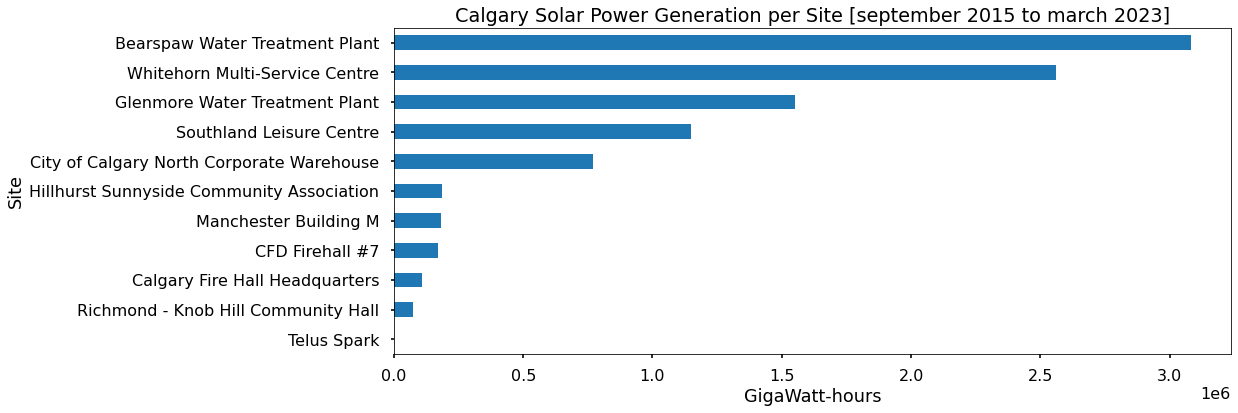

In [190]:
site_totals = site_totals.sort_values(by='kWh', ascending=True)

site_totals.plot(figsize=(15, 6), kind='barh', legend=False)
plt.title('Calgary Solar Power Generation per Site [september 2015 to march 2023]')
plt.xlabel('GigaWatt-hours')
plt.ylabel('Site')

plt.show()

#### Dataframe para análisis de series de tiempo

In [191]:
df['date'] = pd.to_datetime(df['date']) 

df_pw = df.drop(columns= ['name', 'id', 'address', 'public_url', 'installationDate', 'uid'])
df_pw = df_pw.set_index('date')

df_pw.head() 

,kWh
date,
2017-09-11 08:00:00,1.130
2017-09-11 09:00:00,2.340
2017-09-11 10:00:00,3.656
2017-09-11 11:00:00,4.577
2017-09-11 12:00:00,6.506


In [192]:
count_date = df_pw.groupby('date')['kWh'].sum()

pw_clean = pd.DataFrame(count_date)
pw_clean.head()

,kWh
date,
2015-09-01 14:30:00,27.805
2015-09-01 15:30:00,30.559
2015-09-01 16:30:00,23.613
2015-09-01 17:30:00,15.257
2015-09-01 18:30:00,7.896


In [193]:
pw_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36192 entries, 2015-09-01 14:30:00 to 2023-03-16 19:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     36192 non-null  float64
dtypes: float64(1)
memory usage: 565.5 KB


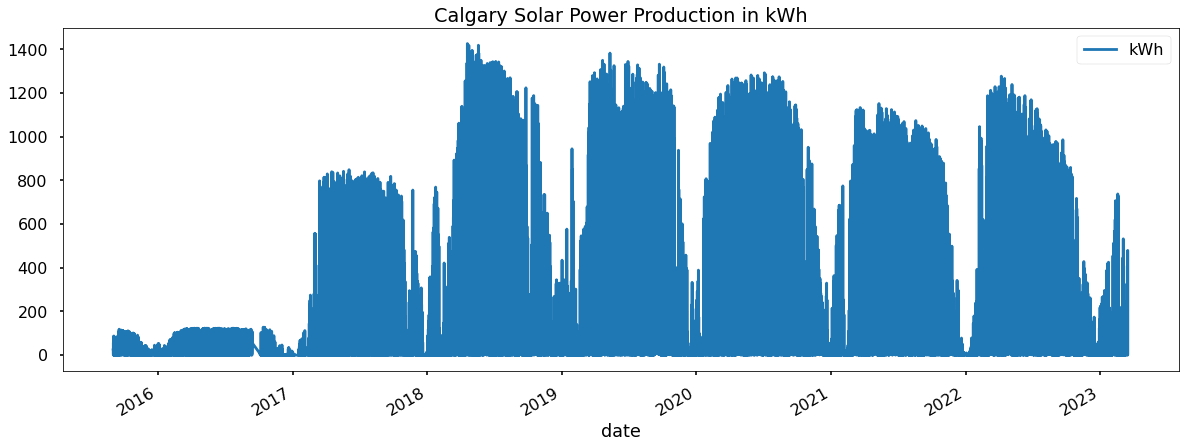

In [194]:
plt.style.use('seaborn-poster')
pw_clean.plot(style='-',
        figsize=(20, 7),
        title='Calgary Solar Power Production in kWh')
plt.show()

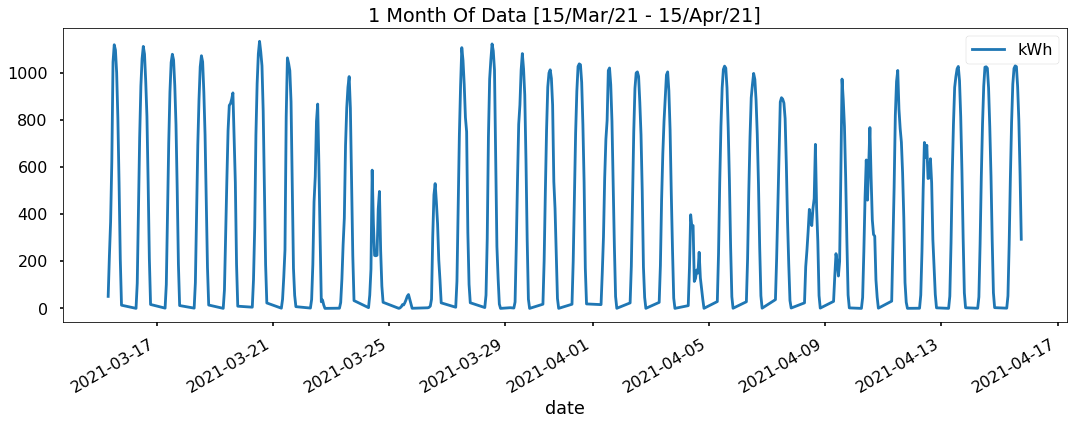

In [195]:
pw_clean.loc[(pw_clean.index > '03-15-2021 07:00:00') & (pw_clean.index < '04-15-2021 19:00:00')] \
    .plot(style='-', figsize=(18, 6), title='1 Month Of Data [15/Mar/21 - 15/Apr/21]')
plt.show()

#### Set de Entrenamiento / Prueba

**Por simplicidad, removemos los datos anteriores a 2017. Observamos que a partir de 2017 se finalizó la instalación de todos los sitios.**  

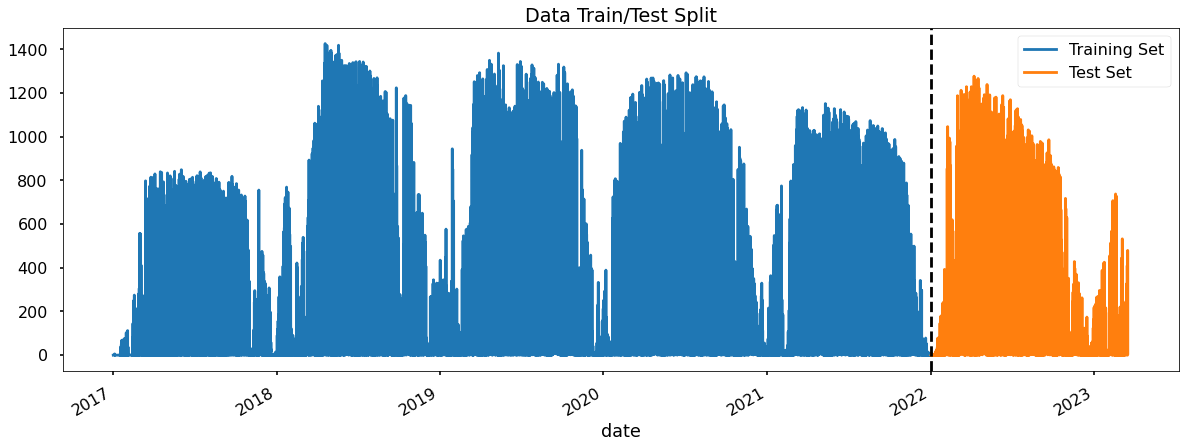

In [196]:
# remove data prior to 2017
pw_clean = pw_clean.loc[pw_clean.index >= '01-01-2017']

# test/train split
train = pw_clean.loc[pw_clean.index < '01-01-2022']
test = pw_clean.loc[pw_clean.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(20, 7))
train.plot(ax=ax, style='-', label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, style='-', label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### **Creación de Atributos (Feature Engineering)**

**Atributos basados en el índice de la serie de tiempo**

In [197]:
#train set
train = train.copy()
train['hour'] = train.index.hour
train['dayofweek'] = train.index.dayofweek
train['weekofyear'] = train.index.isocalendar().week
train['month'] = train.index.month
train['quarter'] = train.index.quarter
train['year'] = train.index.year
train['dayofyear'] = train.index.dayofyear 

#test set
test = test.copy()
test['hour'] = test.index.hour
test['dayofweek'] = test.index.dayofweek
test['weekofyear'] = test.index.isocalendar().week
test['month'] = test.index.month
test['quarter'] = test.index.quarter
test['year'] = test.index.year
test['dayofyear'] = test.index.dayofyear 

#### Visualizacion de attributos contra target

**kWh por hora del día**

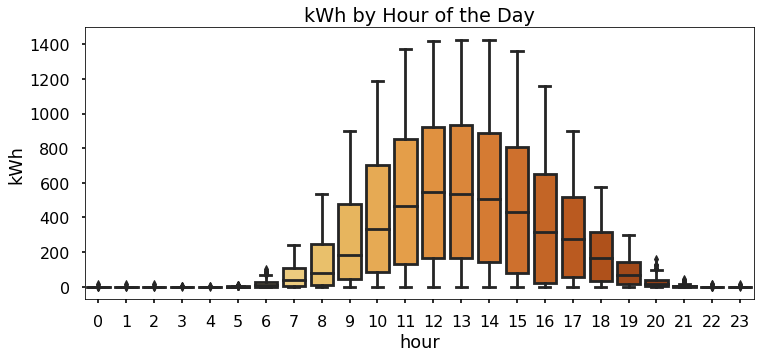

In [198]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='hour', y='kWh', palette='YlOrBr')
ax.set_title('kWh by Hour of the Day')
plt.show()

**kWh por Mes**

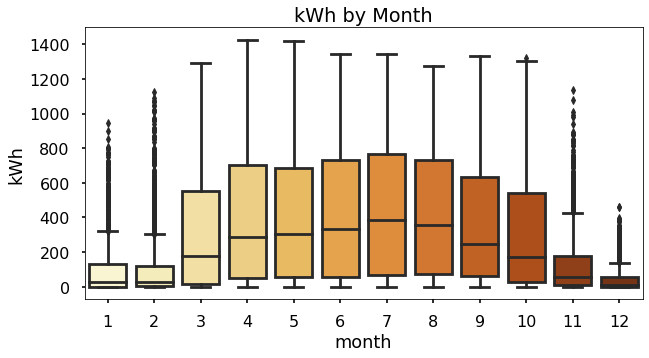

In [199]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=train, x='month', y='kWh', palette='YlOrBr')
ax.set_title('kWh by Month')
plt.show()

*Los meses de invierno (noviembre, diciembre, enero y febrero) con muchos outliers.*

**Atributos "Lag" (Lag attributes)**

### **Modelado**

In [200]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error 

#### 1. Validación cruzada (Cross Validation)

https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split 

In [201]:
pw_clean = pw_clean.loc[pw_clean.index >= '01-01-2017'].sort_index()
ts_cv = TimeSeriesSplit(n_splits=5)

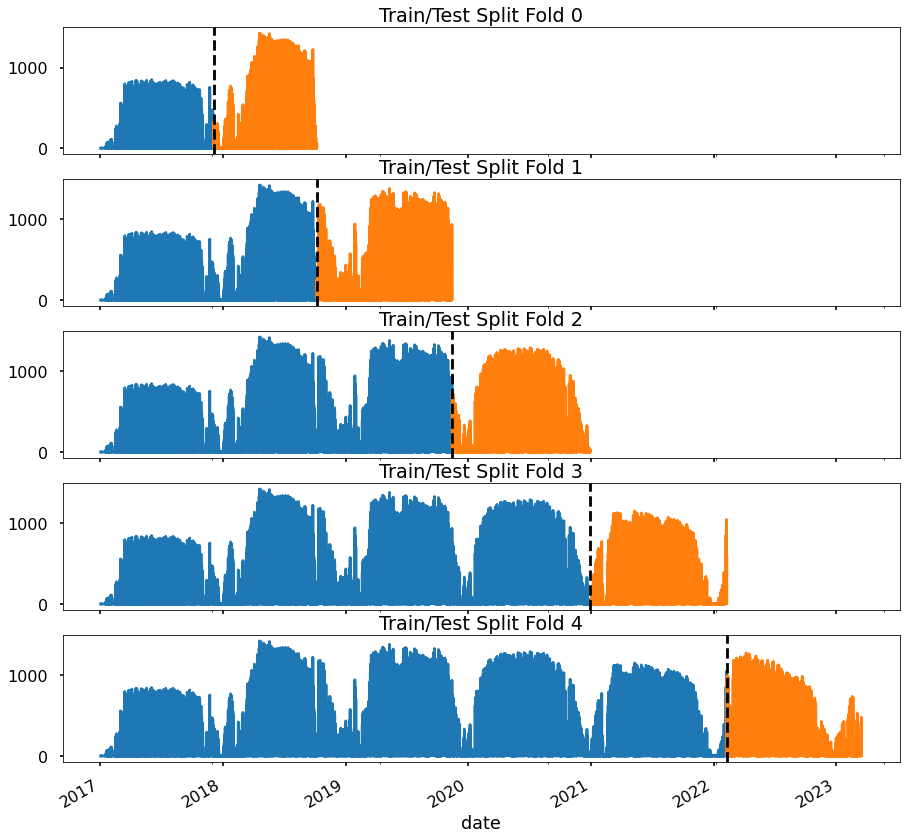

In [202]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test = pw_clean.iloc[val_idx]
    train['kWh'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train/Test Split Fold {fold}')
    test['kWh'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

#### 2. Entrenando el modelo

In [203]:
pw_clean = pw_clean.loc[pw_clean.index >= '01-01-2017'].sort_index()
ts_cv = TimeSeriesSplit(n_splits=5)

fold = 0
preds = []
scores = []

for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test = pw_clean.iloc[val_idx]

    #train set
    train = train.copy()
    train['hour'] = train.index.hour
    train['dayofweek'] = train.index.dayofweek
    train['month'] = train.index.month
    train['quarter'] = train.index.quarter
    train['year'] = train.index.year
    train['dayofyear'] = train.index.dayofyear 
   #test set
    test = test.copy()
    test['hour'] = test.index.hour
    test['dayofweek'] = test.index.dayofweek
    test['month'] = test.index.month
    test['quarter'] = test.index.quarter
    test['year'] = test.index.year
    test['dayofyear'] = test.index.dayofyear

    features = ['hour','dayofweek','month','quarter','year','dayofyear']
    target = ['kWh']
    
    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                               random_state=42,        
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:squarederror',
                               max_depth=5,
                               learning_rate=0.01)

    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:331.29464	validation_1-rmse:499.52509
[100]	validation_0-rmse:168.30814	validation_1-rmse:344.93985
[200]	validation_0-rmse:124.09635	validation_1-rmse:293.96261
[300]	validation_0-rmse:111.05275	validation_1-rmse:276.49518
[400]	validation_0-rmse:105.31348	validation_1-rmse:270.41132
[500]	validation_0-rmse:101.88400	validation_1-rmse:268.40528
[600]	validation_0-rmse:98.54114	validation_1-rmse:267.41681
[700]	validation_0-rmse:95.66552	validation_1-rmse:267.30493
[724]	validation_0-rmse:95.07154	validation_1-rmse:267.31267
[0]	validation_0-rmse:422.97621	validation_1-rmse:524.62092
[100]	validation_0-rmse:223.83963	validation_1-rmse:311.36115
[200]	validation_0-rmse:170.60508	validation_1-rmse:275.18784
[289]	validation_0-rmse:157.67588	validation_1-rmse:272.87167
[0]	validation_0-rmse:459.41589	validation_1-rmse:514.14214
[100]	validation_0-rmse:252.55582	validation_1-rmse:296.62773
[200]	validation_0-rmse:199.08941	validation_1-rmse:247.94523
[300]	validation_

**Importancia de atributos**

In [204]:
feat_imp = pd.DataFrame(xgb_reg.feature_importances_,
                        index=xgb_reg.feature_names_in_,
                        columns=['Importance'])

feat_imp.sort_values('Importance', ascending=False)

,Importance
hour,0.455142
dayofyear,0.306074
year,0.123557
month,0.105187
dayofweek,0.010038
quarter,0.000000


#### 3. Evaluación del modelo

In [205]:
print('Avg. Score:', np.mean(scores))
print('Fold scores:', scores)

Avg. Score: 236.10305243557258
Fold scores: [267.2997898435899, 272.6444080076149, 241.3636884678037, 200.2581315029618, 198.9492443558926]


### **Predicciones** 

#### 1. Re-entrenamos el modelo con el dataset completo

In [206]:
#full dataset
pw_clean = pw_clean.copy()
pw_clean['hour'] = pw_clean.index.hour
pw_clean['dayofweek'] = pw_clean.index.dayofweek
pw_clean['month'] = pw_clean.index.month
pw_clean['quarter'] = pw_clean.index.quarter
pw_clean['year'] = pw_clean.index.year
pw_clean['dayofyear'] = pw_clean.index.dayofyear 

features = ['hour','dayofweek','month','quarter','year','dayofyear']
target = ['kWh']

X_full = pw_clean[features]
y_full = pw_clean[target]

In [207]:
xgb_regf = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                               random_state=42,        
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:squarederror',
                               max_depth=5,
                               learning_rate=0.01)

xgb_regf.fit(X_full, y_full,
        eval_set=[(X_full, y_full)],
        verbose=100)

[0]	validation_0-rmse:470.49062
[100]	validation_0-rmse:262.44873
[200]	validation_0-rmse:211.11206
[300]	validation_0-rmse:198.80827
[400]	validation_0-rmse:194.56749
[500]	validation_0-rmse:191.75133
[600]	validation_0-rmse:189.50864
[700]	validation_0-rmse:187.36164
[800]	validation_0-rmse:185.75406
[900]	validation_0-rmse:184.13292
[999]	validation_0-rmse:182.51687


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

#### 2. Crear dataframe futuro

In [208]:
pw_clean.index.max()

Timestamp('2023-03-16 19:00:00')

**2 meses en el futuro**

In [215]:
#march to may 2023
pred_dates = pd.date_range('2023-03-17','2023-05-17', freq='1h')
preds_df = pd.DataFrame(index=pred_dates)

#Create column with booleans where future dates = True
preds_df['Future'] = True

pw_clean['Future'] = False

#Concatenate both df's
pred_pw = pd.concat([pw_clean, preds_df]) 

In [216]:
#add features
pred_pw = pred_pw.copy()
pred_pw['hour'] = pred_pw.index.hour
pred_pw['dayofweek'] = pred_pw.index.dayofweek
pred_pw['month'] = pred_pw.index.month
pred_pw['quarter'] = pred_pw.index.quarter
pred_pw['year'] = pred_pw.index.year
pred_pw['dayofyear'] = pred_pw.index.dayofyear 

pred_pw.tail()

,kWh,hour,dayofweek,month,quarter,year,dayofyear,Future
2023-05-16 20:00:00,NaN,20,1,5,2,2023,136,True
2023-05-16 21:00:00,NaN,21,1,5,2,2023,136,True
2023-05-16 22:00:00,NaN,22,1,5,2,2023,136,True
2023-05-16 23:00:00,NaN,23,1,5,2,2023,136,True
2023-05-17 00:00:00,NaN,0,2,5,2,2023,137,True


In [217]:
#create df with future dates only
future_pred_pw = pred_pw.query('Future').copy()
future_pred_pw.head()

,kWh,hour,dayofweek,month,quarter,year,dayofyear,Future
2023-03-17 00:00:00,NaN,0,4,3,1,2023,76,True
2023-03-17 01:00:00,NaN,1,4,3,1,2023,76,True
2023-03-17 02:00:00,NaN,2,4,3,1,2023,76,True
2023-03-17 03:00:00,NaN,3,4,3,1,2023,76,True
2023-03-17 04:00:00,NaN,4,4,3,1,2023,76,True


#### 3. Prediciendo el futuro

In [218]:
#create column with predictions
future_pred_pw['prediction'] = xgb_regf.predict(future_pred_pw[features])

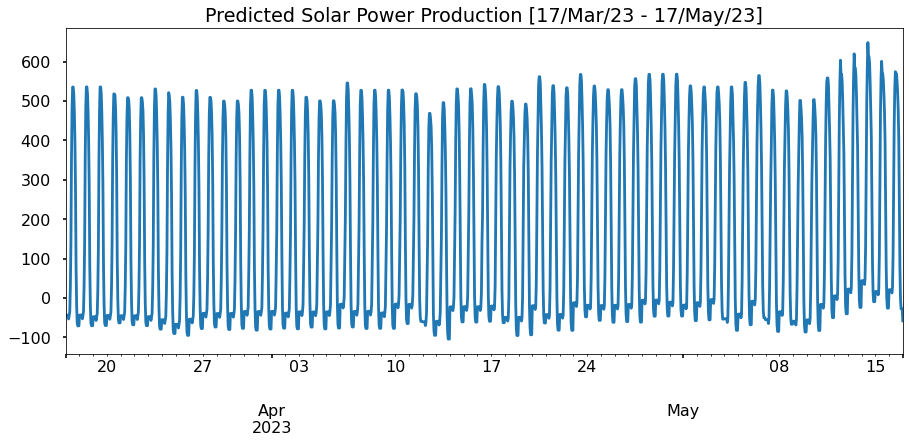

In [221]:
future_pred_pw['prediction'].plot(figsize=(15, 6),
                                  title='Predicted Solar Power Production [17/Mar/23 - 17/May/23]')
plt.show()